In [598]:
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import json
#import seaborn as sns
import numpy as np
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm as cm
import importlib
import matplotlib.patches as mpatches
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
from urllib.parse import urlparse

In [316]:
df = pd.read_csv('../data/unique_df_with_scores.csv')

In [606]:
df[df.journal_impact < 2]['doi']

88        10.1080/14681994.2017.1419558
89        10.1080/14681994.2017.1419558
137                  10.1111/coep.12115
140        10.1016/j.specom.2013.06.006
141       10.1080/17531055.2016.1250871
                      ...              
125586                 10.1002/bdm.2071
125587                 10.1002/bdm.2071
125662                 10.1063/1.523304
125678        10.11646/zootaxa.4299.3.1
125679        10.11646/zootaxa.4299.3.1
Name: doi, Length: 5277, dtype: object

In [605]:
len(df)

125685

In [578]:
df['domain'] = [extract_domain(url) for url in df['url']]

In [591]:
#df[['domain','category']].to_csv('../data/url_domain.csv', index=False)

In [17]:
statements

['News story is interesting to me',
 'Needs specialized knowledge',
 'News story is fun to read',
 'Should be published in news',
 'Tackles an important issue',
 'I understand the news story',
 'Could interest the general public',
 'Finding is surprising to me',
 'Finding could be controversial',
 'Could benefit many people',
 'News story is exaggerated',
 'I learned something useful',
 'Would share directly',
 'Would share on wider forum',
 'Unlikely to share',
 'Policy makers',
 'A public segment',
 'Related industry companies',
 'General public',
 'Other popular media',
 'Popular print media',
 'Sci-Tech media',
 'My social media feed',
 'General news outlets',
 "Shouldn't be public outside science"]

In [424]:
statements = ['News story is interesting to me', 'Needs specialized knowledge', 'News story is fun to read', 'Should be published in news', 'Tackles an important issue', 'I understand the news story', 'Could interest the general public', 'Finding is surprising to me', 'Finding could be controversial', 'Could benefit many people', 'News story is exaggerated', 'I learned something useful', 'Would share directly', 'Would share on wider forum', 'Unlikely to share', 'Policy makers', 'A public segment', 'Related industry companies', 'General public', 'Other popular media', 'Popular print media', 'Sci-Tech media', 'My social media feed', 'General news outlets', "Shouldn't be public outside science"]
fields = ['Sociology', 'Psychology', 'Political_science', 'Physics', 'Medicine', 'Mathematics',
         'History', 'Geology', 'Geography', 'Environmental_science', 'Engineering', 'Economics', 'Computer_science',
         'Chemistry', 'Business', 'Biology']
sel_statements = {
    'Should be published in news': 'Newsworthiness',
    'Tackles an important issue': 'Importance',
    'I understand the news story': 'Understandability',
    'Could benefit many people': 'Benefit',
    'Could interest the general public': 'Interestingness',
    'News story is fun to read': 'Fun',
    #'Finding is surprising to me': 'Surprisingness',
    #'Would share on wider forum': 'Sharing'
}

In [317]:
df = df.rename(columns=sel_statements)

In [577]:
def extract_domain(url):
    parsed_url = urlparse(url)
    if parsed_url.netloc.startswith('www.'):
        return parsed_url.netloc[4:]
    else:
        return parsed_url.netloc
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    se = results.bse
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"p value":pvals,
                               "coeff":coeff,
                               "SE":se,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df.reset_index()
    results_df['term'] = results_df['index']
    return results_df

def add_star(p):
    sig = ' '
    if p < 0.05:
        sig = '*'
    else:
        sig = ' '
    if p < 0.01:
        sig = '**'
    if p < 0.001:
        sig = '***'
   
    return sig

def plot_reg_results_dv_pointplot(plot_df, dvs, terms=None, labels=None, figsize=(8, 6), title='', figtype='pointplot',cmap = 'plasma',baseline=0.00,baseline_text='',
                             filename=None, legend=None, wspace=0.35, yticks=None, ytick_labels=None, ylabel=None, ylim=None, xlabel=None, sig=True):
    fig, ax = plt.subplots(figsize=figsize)
    if figtype == 'pointplot_with_pct':
        ax2 = ax.twinx()
        ax.set_zorder(1)  # default zorder is 0 for ax1 and ax2
        ax.patch.set_visible(False)  # prevents ax1 from hiding ax2
    
    plt.tight_layout()
    #plt.title(title, pad=0.1)
    st = fig.suptitle("", fontsize=14)
    if terms:
        plot_df = plot_df[(plot_df['term'].isin(terms))]

    # Create a colormap for differentiating dvs values
    cmap = cm.get_cmap(cmap, len(dvs))

    for i, dv in enumerate(dvs):
        df = plot_df[(plot_df['dv'] == dv)]
        xs = df['coeff']
        colors = cmap(i)
        en_len = int(len(df))

        ax.set_xlim(-0.7, len(df['term'][:len(set(df['term']))]) - 0.2)
        ax.axhline(y=baseline, color='black', linewidth=1.0, linestyle='--')
        ax.text(1, 0.0, baseline_text, ha='center', va='top',
            transform=ax.get_yaxis_transform())

        if ylabel:
            ax.set_ylabel(ylabel, fontsize=14)
        if xlabel:
            ax.set_xlabel(xlabel, fontsize=14)
        if ylim:
            ax.set_ylim(ylim[0], ylim[1])
        if yticks:
            ax.set_yticks(yticks)
        

        s = 0
        en = en_len
        for x, y, e, p in zip(df['coeff'][s:en], df['term'][s:en], df['SE'][s:en], df['p value'][s:en]):
            if figtype == 'errorbar':
                ax.errorbar(x=[y], y=[x], yerr=[e], color=colors, fmt='o', label=dv if s == 0 else None)
            elif figtype == 'pointplot':
                ax.plot(df['term'], xs, color=colors, label=dv if s == 0 else None, marker='o', linestyle='-')
                ax.errorbar(x=[y], y=[x], yerr=[e], color=colors, fmt='o', label=None)
            elif figtype == 'pointplot_with_pct':
                
                ax.plot(df['term'], xs, color=colors, label=None, marker='o', linestyle='-')
                ax.errorbar(x=[y], y=[x], yerr=[e], color=colors, fmt='o', label=None)
                ax2.bar(df['term'], df['pct'], color=['#D3D3D3']*len(df), label=None,alpha=0.08)
                ax2.set_ylabel('Change in %', fontsize=14)
                
            elif figtype == 'bar':
                ax.bar(x=[y], height=[x], yerr=[e], color=colors, label=dv if s == 0 else None)
            sig_str = ' '
            if p < 0.05:
                sig_str = '*'
            if p < 0.01:
                sig_str = '**'
            if p < 0.001:
                sig_str = '***'
            ax.annotate(sig_str,
                        (y, x + 0.00001),
                        textcoords="offset points",
                        xytext=(-0.5, 0),
                        ha='center')
            s += 1

        ax.set_xticklabels(list(df['term']), fontsize=14)
        if ytick_labels:
            ax.set_yticklabels(ytick_labels, fontsize=14)
        ax.set_title(r"%s" % (title if title else dv), fontsize=14)
        
    #plot.set_zorder(ax.get_zorder()+10)
            
    st.set_y(-0.02)
    #fig.text(0.5, -0.01, s="%s" % title, ha='center', fontsize=14)
    if sig:
        fig.text(0.5, -0.18, s="Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05", ha='center', fontsize=9)
    if legend:
        ax.legend(handles=legend['handles'], loc=legend['loc'], ncol=legend['ncol'], bbox_to_anchor=legend['bbox_to_anchor'])
    elif legend != False:
        # Get all handles and labels
        handles, labels = ax.get_legend_handles_labels()
        print(handles, labels)

        # Remove handles with the same label and retain only unique labels
        unique_labels, unique_handles = [], []
        for handle, label in zip(handles, labels):
            if label not in unique_labels:
                unique_labels.append(label)
                unique_handles.append(handle)

        # Create a legend with unique handles and labels
        ax.legend(unique_handles, unique_labels, loc='upper right')
    
    if filename:
        plt.savefig('../figures/%s.pdf' % filename, bbox_inches='tight')

        
def plot_reg_results(df, nrows = 1, ncols = 1, figsize=(4, 2), xlabel='xlabel', ylabel='',labels = None, baseline='', title='', filename=None):
    #df = df.sort_values('coeff')
    xs = df['coeff']
    norm = matplotlib.colors.Normalize(vmin=min(xs)*2, vmax=max(xs)*2)
    mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
    colors = np.array([(mapper.to_rgba(v)) for v in xs])
    en_len = int(len(df))
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes=[axes] if nrows + ncols <= 2 else axes
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.6)
    #plt.title('Uncertainty in Fields')
    st = fig.suptitle("", fontsize=14)
    #sigg = fig.suptitle("Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1", fontsize=14)
    for i in range(len(axes)):
        ax = axes[i]
        ax.set_ylim(-0.7, len(df['term'][:en_len])-0.2)
        ax.axvline(x=0.00,color='black',linewidth=1.7,linestyle='-')
        ax.text(0.00, 1.1, baseline, ha='center', va='top',
            transform=ax.get_xaxis_transform())
        ax.xaxis.grid(True)
        #ax.yaxis.label.set_color('white')
        #ax.set_xticks([-0.5, 0.0, 0.5, 1,0])
        #ax.set_xlabel(r"%s ($\beta$ coef.)"%xlabel, fontsize=14)
        ax.set_xlabel(xlabel,fontsize=14)
        ax.set_ylabel(ylabel,fontsize=14)
        #ax.set_xticks([-0.04, -0.02, 0, 0.02, 0.04])
        #ax.set_title(r"%s"%(labels[i] if labels else dvs[i]), fontsize=14)
        s = en_len*i
        en = en_len*(i+1)
        for x, y, e, p, color in zip(df['coeff'][s:en], df['term'][s:en], df['SE'][s:en],df['p value'][s:en], colors[s:en]):
            #plt.plot(x, y, 'o', color=color)
            ax.errorbar(x=[x], y=[y], xerr=[e], color=color,fmt='o')
            sig = ' '
            if p < 0.05:
                sig = '*'
            if p < 0.01:
                sig = '**'
            if p < 0.001:
                sig = '***'
            ax.annotate(sig, # this is the text
                     (x+0.00001,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-0.5), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

        #ax.set_xticklabels([-0.04, -0.02, 0, 0.02, 0.04], fontsize=14)
        ax.set_yticklabels(list(df['term']), fontsize=14)

    #fig.text(0.5, 0.04, 'common X', ha='center')
    st.set_y(-0.02)
    #sigg.set_y(-0.12)
    #fig.text(0, 5, s="%s"%baseline,ha='center',va='top',fontsize=14)
    fig.text(0.5, -0.17, s="%s"%title,ha='center',fontsize=14)
    fig.text(0.5, -0.18, s="Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05",ha='center',fontsize=9)
    if filename:
        plt.savefig('../figures/%s.pdf'%filename, bbox_inches='tight')

def radar_plots_grid(dataframe, n_rows, n_cols, subplot_width=400, subplot_height=400, label_font_size=12):
    # Extract subject names and dimension values
    subjects = dataframe['single_field']
    dimensions = list(dataframe.columns[1:])  # Assuming the dimensions start from the second column

    # Create subplots with NxM layout
    fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=subjects, specs=[[{'type': 'polar'}]*n_cols]*n_rows)

    # Counter for the current subject
    subject_count = 0

    for i in range(1, n_rows + 1):
        for j in range(1, n_cols + 1):
            if subject_count < len(subjects):
                subject = subjects[subject_count]
                values = dataframe.loc[subject_count, dimensions].tolist()
                values += values[:1]  # Close the plot by adding the first value to the end

                trace = go.Scatterpolar(
                    r=values,
                    theta=dimensions + [dimensions[0]],  # Close the plot
                    fill='toself',
                    name=subject
                )

                fig.add_trace(trace, row=i, col=j)

                subject_count += 1

    # Customize radial axis ticks and labels
    tick_values = [0.2, 0.4, 0.6, 0.8, 1.0]  # Adjust these values as needed
    tick_labels = [f"{val:.1f}" for val in tick_values]  # Format tick labels

    for i in range(1, n_rows * n_cols + 1):
        fig.update_layout(
            polar=dict(radialaxis_tickvals=tick_values, radialaxis_ticktext=tick_labels, radialaxis_title_font_size=label_font_size)
        )

    # Update subplot layout
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[2, 4]  # Customize the range of the radial axis if needed
            ),
        ),
        showlegend=False,  # Remove the legend
        title_text='Radar Plots Grid',
        width=subplot_width,
        height=subplot_height
    )

    # Show the grid of radar plots
    fig.show()

def normalize_df(df):
    return (df-df.min())/(df.max()-df.min())

def radar_plot_grid(df, n, m, title=''):
        # Extract the dimension names and values
    dimensions = df.columns[1:]
    values = df[dimensions].values

    # Number of dimensions
    num_dimensions = len(dimensions)

    # Calculate the average values for each dimension across all subjects
    average_values = values.mean(axis=0).tolist()

    # Calculate the number of plots required
    num_plots = len(df)

    # Calculate the number of rows and columns in the grid
    rows = math.ceil(num_plots / m)
    cols = min(num_plots, m)

    # Create an array of evenly spaced angles for the radar chart
    angles = np.linspace(0, 2 * np.pi, num_dimensions, endpoint=False).tolist()
    angles += angles[:1]  # Repeat the first angle to close the plot

    # Create the grid of radar plots
    fig, axes = plt.subplots(rows, cols, figsize=(16, 10), subplot_kw={'polar': True})
    fig.subplots_adjust(hspace=0.4, wspace=0.2)

    # Loop through each subject and create a radar plot in the grid
    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            subject = df.loc[i, 'single_field']
            subject_values = df.loc[i, dimensions].tolist()

            # Create a radar plot for the current subject
            ax.fill(angles, average_values + [average_values[0]], 'lightgrey', alpha=0.5)
            # Plot the average values as a line plot on the same radar chart
            ax.plot(angles, subject_values + [subject_values[0]], '-', linewidth=1.5) # Red dashed line for averages

            ax.set_rgrids([0.5, 1.0])
            # Set the labels for the angles
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(dimensions, fontsize=8)

            # Add the title for the current subject
            ax.set_title(f'{subject}')

    # Remove empty subplots, if any
    for i in range(num_plots, rows * cols):
        fig.delaxes(axes.flat[i])

    # Add a common title for the entire grid
    plt.suptitle(title, fontsize=22)
    
    # Show the grid of radar plots
    #plt.show()
    plt.savefig('../shared_data/figures/subject_estimated_perceived_newsvalues.pdf', bbox_inches='tight')

In [202]:
t_df

,single_field,News,Imp,Und,Benf,Int,Fun
0,Biology,0.611869,0.635831,0.631991,0.634572,0.671026,0.502642
1,Business,0.822487,0.786034,0.830536,0.735831,0.815041,0.444010
2,Chemistry,0.511923,0.689569,0.436909,0.644670,0.479131,0.363000
3,Computer_science,0.588372,0.506258,0.687098,0.543035,0.692024,0.564869
4,Economics,0.752220,0.767207,0.827259,0.670324,0.794929,0.302461
5,Engineering,0.658862,0.581857,0.735204,0.582252,0.722331,0.511062
6,Environmental_science,0.903210,0.898431,0.800252,0.783793,0.789387,0.424612
7,Geography,0.686579,0.474487,0.908365,0.398977,0.768808,0.634138
8,Geology,0.689449,0.410127,0.717476,0.255858,0.637164,0.673734
9,History,0.418040,0.107330,0.938492,0.099282,0.705028,0.804736


In [313]:
df

,has_indirect_mention,mentions_first_author_institution,has_first_author_quote,url,doi,first_aut_name,first_aut_last_name,first_fname_length,first_fname_prob,eth_first_author_ethnea,...,Could_interest_the_general_public,I_learned_something_useful,A_public_segment,News_story_is_exaggerated,Popular_print_media,Would_share_directly,General_news_outlets,Shouldnt_be_public_outside_science,Sci_Tech_media,coverage_type
0,False,False,False,http://www.sciencedaily.com/releases/2013/11/1...,10.1016/j.neuron.2013.08.030,Hanneke E.M. den Ouden,Ouden,5,0.000000,DUTCH,...,2.296291,2.465199,2.686415,1.301581,1.902833,1.519329,2.308816,1.281604,2.319536,pr_sci_covered
1,False,False,True,http://www.sciencedaily.com/releases/2013/09/1...,10.1016/j.neuron.2013.08.003,Andrii Rudenko,Rudenko,7,-1.897120,SLAV,...,2.888732,2.750685,2.689230,1.319639,2.131689,2.088601,2.671594,1.185760,2.625309,pr_sci_covered
2,False,False,False,http://ct.moreover.com/?a=34275251912&p=1pl&v=...,10.1016/j.chb.2016.11.013,Brian A. Primack,Primack,7,-2.207275,ENGLISH,...,3.437256,2.646018,3.382650,1.273578,2.441882,2.373133,3.010268,0.779400,2.300230,all_covered
3,False,False,True,http://www.sciencedaily.com/releases/2014/04/1...,10.1093/scan/nsu039,Ekaterina Denkova,Denkova,7,0.000000,SLAV,...,3.447606,2.475925,2.752138,1.267563,2.896600,2.008687,2.717155,0.836890,2.135781,all_covered
4,False,True,True,http://www.sciencedaily.com/releases/2015/03/1...,10.1002/ana.24367,James H. Cole,Cole,4,4.192680,ENGLISH,...,3.361199,3.317885,3.370987,1.159560,2.333585,2.663016,3.171862,0.806373,3.236556,pr_only_covered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125680,False,False,False,http://ct.moreover.com/?a=34634051688&p=1pl&v=...,10.1016/j.jtemb.2012.04.020,Maureen M. Black,Black,5,3.960051,ENGLISH,...,3.122701,2.814796,3.273838,0.989787,2.114592,2.193996,3.041049,0.896544,2.503951,None
125681,False,False,False,http://ct.moreover.com/?a=38410387813&p=1pl&v=...,10.1016/j.jsat.2018.11.008,Mary Jane Burton,Burton,6,3.623541,ENGLISH,...,2.397258,2.500436,3.231238,1.365028,1.373333,1.372752,2.245460,1.453491,2.316416,None
125682,False,False,False,http://ct.moreover.com/?a=38752139596&p=1pl&v=...,10.1007/s12603-018-1094-5,Puja Agarwal,Agarwal,7,0.609766,INDIAN,...,3.352649,3.032770,3.575300,0.910561,2.571058,2.588718,3.059339,0.744308,2.699315,pr_only_covered
125683,False,False,False,http://ct.moreover.com/?a=38752147474&p=1pl&v=...,10.1007/s12603-018-1094-5,Puja Agarwal,Agarwal,7,0.609766,INDIAN,...,3.381396,3.016055,3.565109,0.983490,2.606001,2.613890,3.041755,0.761627,2.699658,pr_only_covered


In [323]:
fields = ['Social_psychology', 'Biology', 'Medicine', 'Computer_science', 'Ecology', 'Environmental_engineering', 
          'Architecture', 'Demography', 'History', 'Engineering', 'Immunology', 'Chemistry' ]

In [334]:
psych = [it for it in set(df.single_field) if re.search('psy|Psych', it) and it != 'Psychology']

In [332]:
psych

['Developmental_psychology',
 'Cognitive_psychology',
 'Psychology',
 'Psychiatry',
 'Clinical_psychology',
 'Social_psychology',
 'Psychopathology']

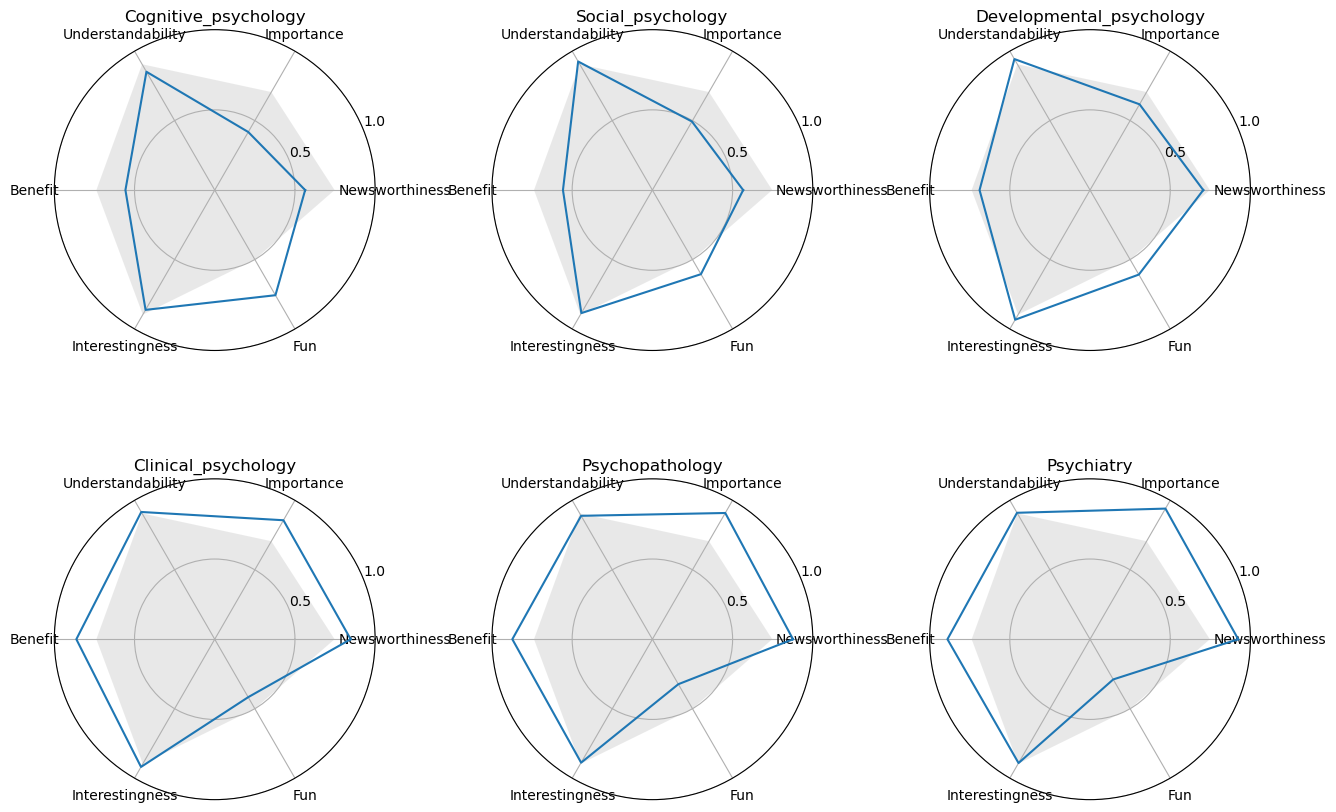

In [335]:
t_df = normalize_df(df.rename(columns=sel_statements)[['single_field'] + list(sel_statements.values())].groupby('single_field').mean()).reset_index()
t_df = t_df[t_df.single_field.isin(psych)].sort_values('Newsworthiness').reset_index().drop(columns=['index'])
#radar_plots_grid(t_df, 4,4, 1000, 1000, 1)
radar_plot_grid(t_df, 4, 3)

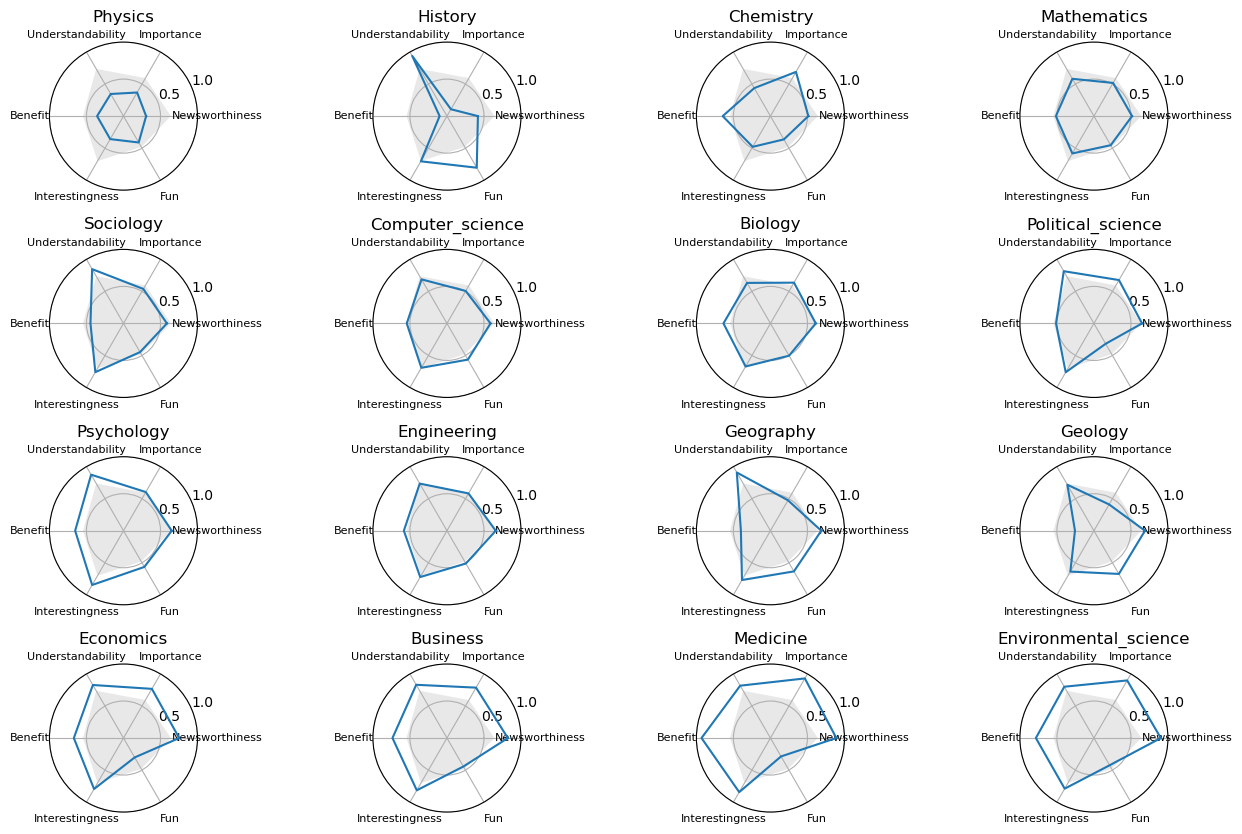

In [429]:
t_df = normalize_df(df.rename(columns=sel_statements)[['single_field'] + list(sel_statements.values())].groupby('single_field').mean()).reset_index()
t_df = t_df[t_df.single_field.isin(fields)].sort_values('Newsworthiness').reset_index().drop(columns=['index'])
#radar_plots_grid(t_df, 4,4, 1000, 1000, 1)
radar_plot_grid(t_df, 4, 4)

<Axes: xlabel='corr', ylabel='dimension'>

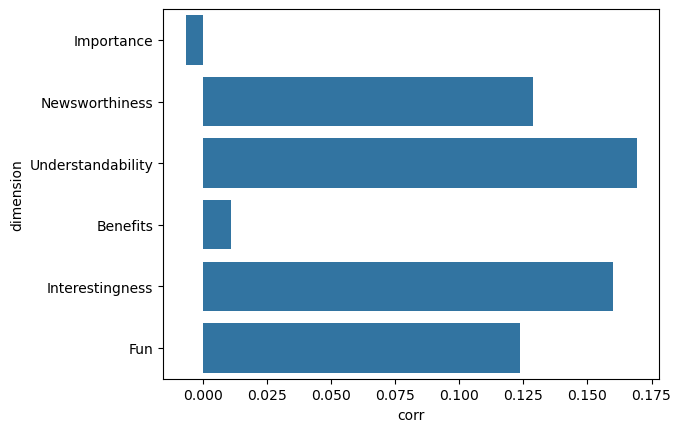

In [186]:
t_df = defaultdict(list)
for k in sel_statements.values():
    t_df['dimension'].append(k)
    t_df['corr'].append(stats.pearsonr(df['coverage_cnt'],df[k])[0])
sns.barplot(y='dimension', x='corr', data=t_df)

/tmp/ipykernel_2810945/991383733.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=1)


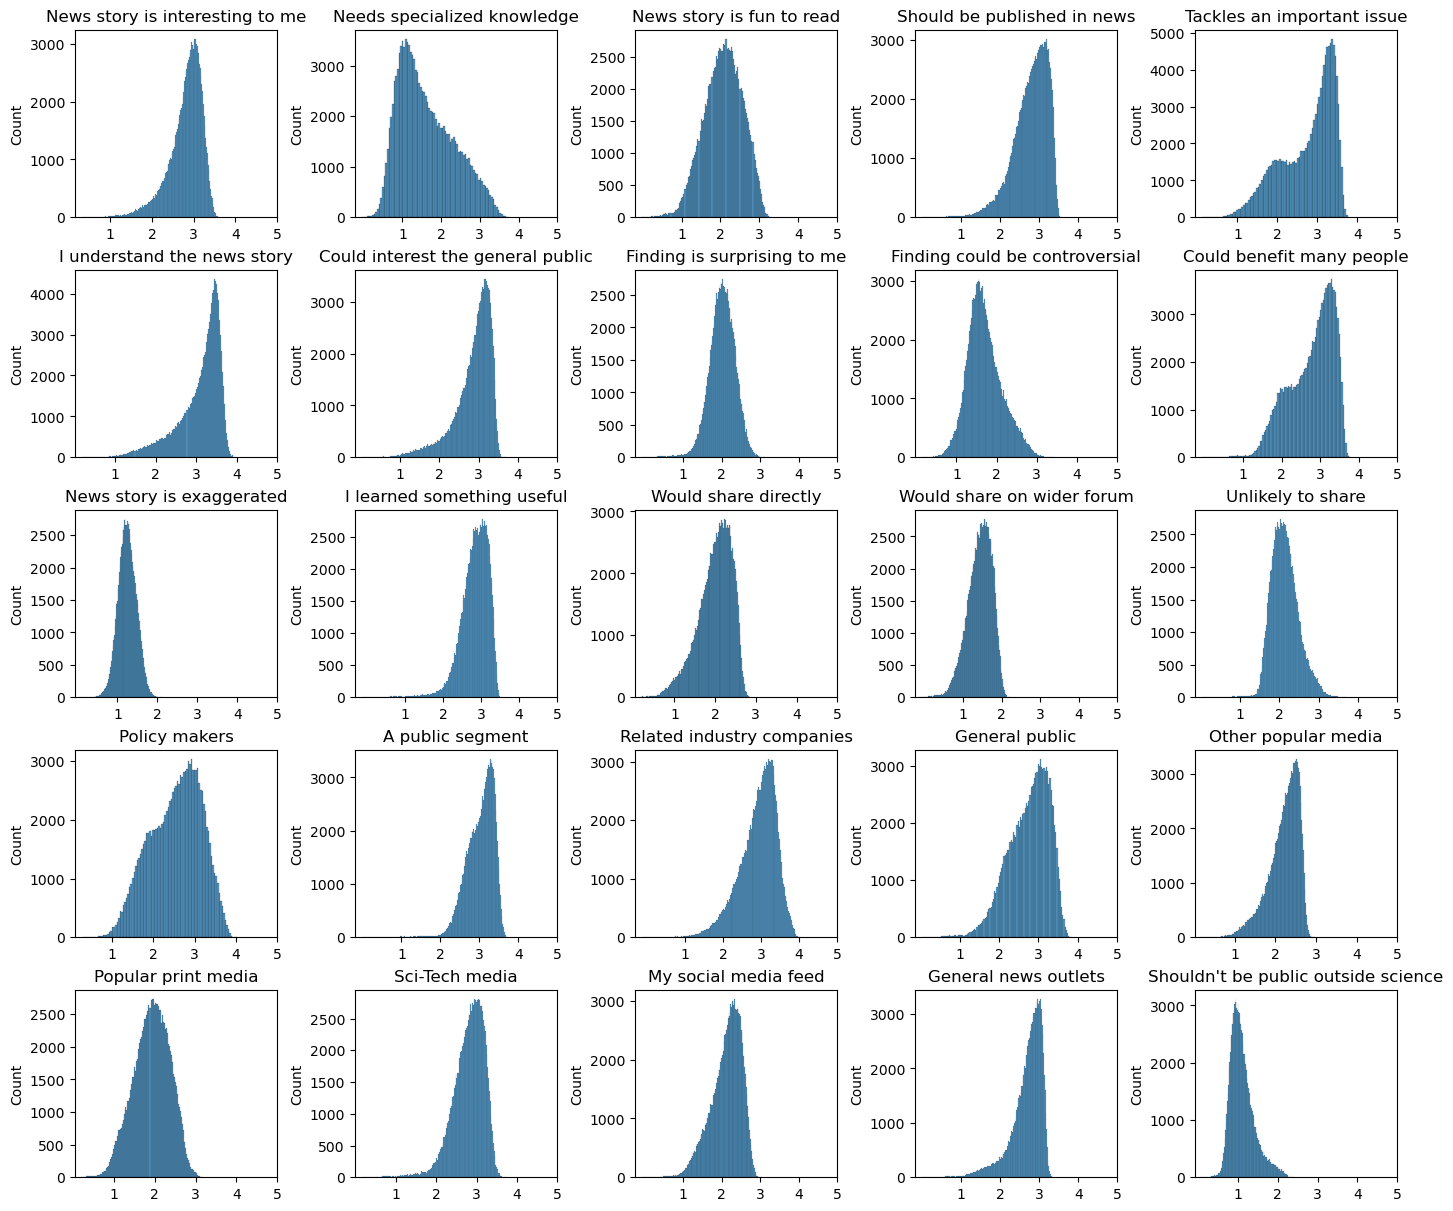

In [4]:
fig, axes = plt.subplots(ncols=5, nrows=5,figsize=(14,12), constrained_layout=True)
plt.subplots_adjust(wspace=1)
for i in range(5):
    for j in range(5):
        ax = axes[i][j]
        s = statements[i*5+j]
        sns.histplot(list(df[s]),ax=ax)
        ax.set_title(s)
        ax.set_xticks([1,2,3,4,5])
        

In [179]:
key = 'Newsworthiness'
df['tgt'] = df[key]
mod = mixedlm(formula = 'tgt' + ' ~ Understandability + Importance + Benefits + Interestingness + big_field',
                      data=df, groups=df['doi'])
res = mod.fit()
print(res.summary())

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      tgt       
No. Observations:      125685       Method:                  REML      
No. Groups:            56686        Scale:                   0.0063    
Min. group size:       1            Log-Likelihood:          96900.2556
Max. group size:       97           Converged:               Yes       
Mean group size:       2.2                                             
-----------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                   -0.019    0.004  -4.808 0.000 -0.027 -0.011
big_field[T.Humanities]     -0.014    0.025  -0.581 0.561 -0.062  0.034
big_field[T.Medicine]       -0.073    0.003 -22.742 0.000 -0.079 -0.067
big_field[T.Others]         -0.054    0.010  -5.301 0.000 -0.074 -0.034
big_field

In [181]:
key = 'coverage_cnt'
df['tgt'] = df[key]
mod = ols(formula = 'tgt' + ' ~ Newsworthiness+ Understandability + Importance + Benefits + Interestingness + big_field',
                      data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    tgt   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     609.0
Date:                Wed, 10 Jan 2024   Prob (F-statistic):               0.00
Time:                        04:50:13   Log-Likelihood:            -4.2053e+05
No. Observations:              125685   AIC:                         8.411e+05
Df Residuals:                  125674   BIC:                         8.412e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [244]:
def get_heatmap(key):
    fig, ax = plt.subplots(figsize=(5,4)) 
    cmap = sns.diverging_palette(10, 0, as_cmap=True)
    sns.heatmap(df[list(sel_statements.values()) + [key]].groupby(key).mean(), cmap=cmap, annot=True)

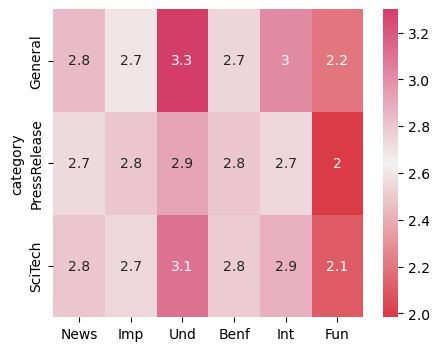

In [245]:
get_heatmap('category')

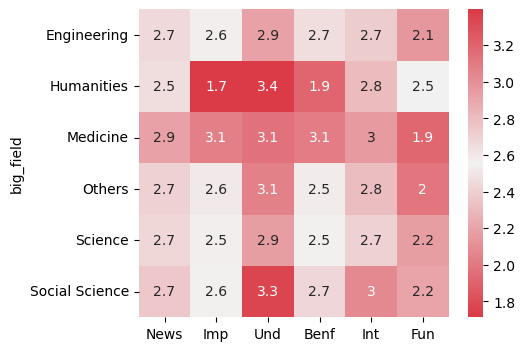

In [227]:
get_heatmap('big_field')

In [349]:
key = 'Newsworthiness'
#df[[key,'cleaned_text']].sort_values(key)

In [210]:
top_fields = fields#set(df.single_field.value_counts()[:30].index)

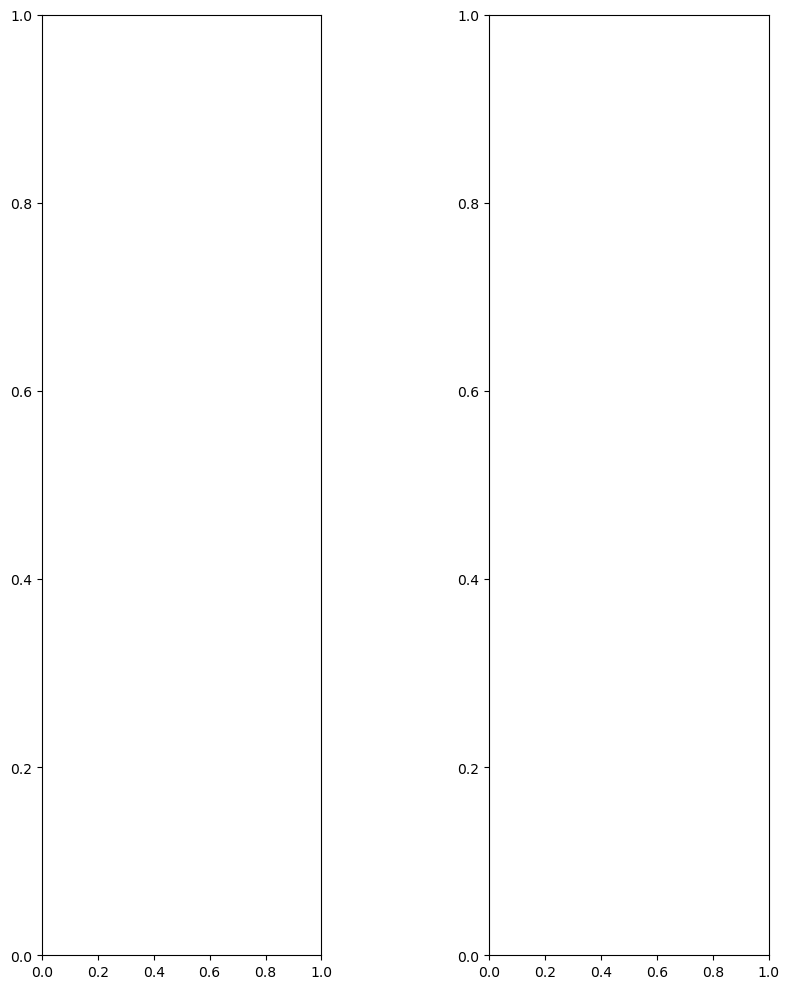

In [363]:
##fig, axes = plt.subplots(ncols = 2, figsize=(8, 10)) 
#plt.tight_layout()
#plt.subplots_adjust(wspace=0.6)
t_df = df[df['single_field'].isin(top_fields)][['single_field',key]].groupby('single_field').mean().reset_index().sort_values('single_field')
t_df['count'] = df[df['single_field'].isin(top_fields)][['single_field',key]].groupby('single_field').count().reset_index().sort_values('single_field')[key]
t_df['value_rank'] = t_df[key].rank(ascending=False)
t_df['count_rank'] = t_df['count'].rank(ascending=False)
t_df = t_df.sort_values('count')
#sns.pointplot(y='single_field', x='count', data=t_df, join=False, ax=axes[0])
#sns.pointplot(y='single_field', x=key, data=t_df, join=False, ax=axes[1])

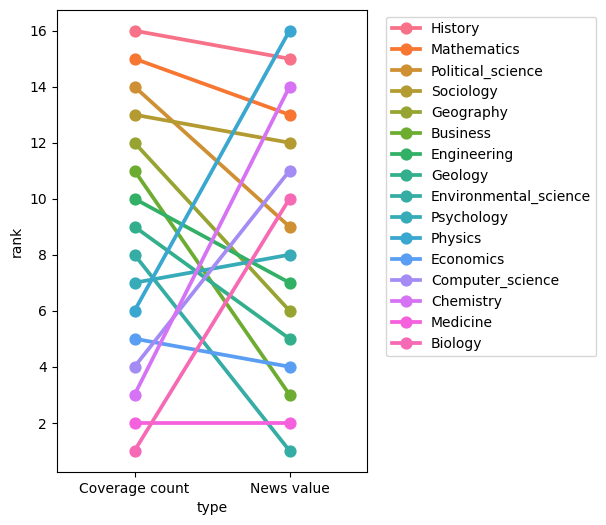

In [213]:
fig, axes = plt.subplots(figsize=(4, 6)) 
s_df = pd.concat([t_df,t_df])
s_df['rank'] = list(t_df['value_rank']) + list(t_df['count_rank'])
s_df['type'] = ['News value'] * len(t_df) + ['Coverage count'] * len(t_df)
sns.pointplot(x='type', y='rank', hue='single_field',data=s_df, order=['Coverage count', 'News value'])
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


<Axes: xlabel='count', ylabel='single_field'>

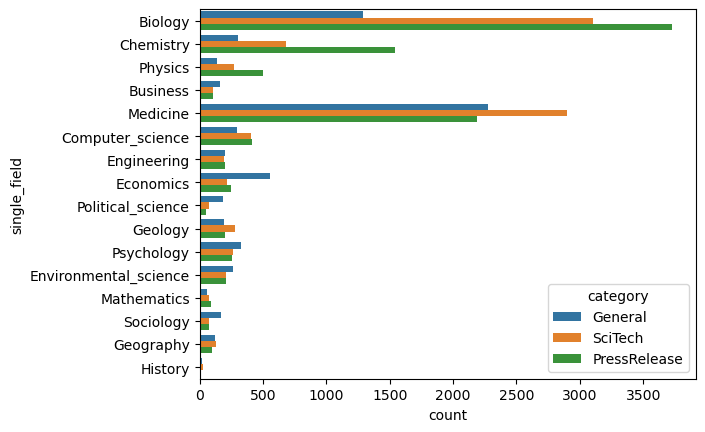

In [439]:
sns.countplot(y='single_field', hue='category', data=df[df['single_field'].isin(top_fields)])

<Axes: xlabel='Newsworthiness', ylabel='single_field'>

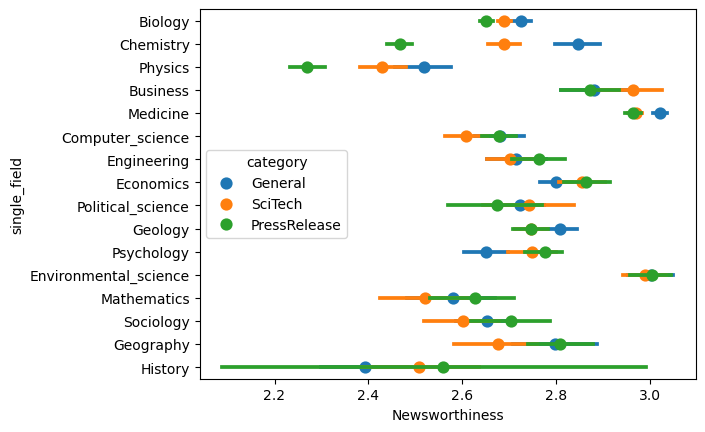

In [445]:
sns.pointplot(y='single_field',x='Newsworthiness', hue='category', data=df[df['single_field'].isin(top_fields)], linestyle='none')

<Axes: xlabel='Importance', ylabel='single_field'>

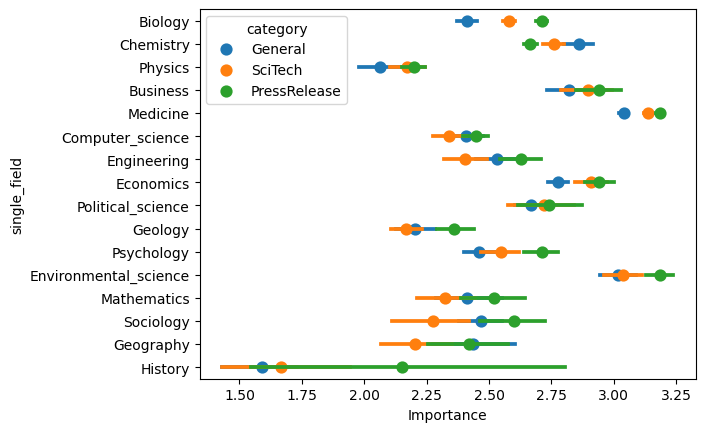

In [447]:
sns.pointplot(y='single_field',x='Importance', hue='category', data=df[df['single_field'].isin(top_fields)], linestyle='none')

<Axes: xlabel='Interestingness', ylabel='single_field'>

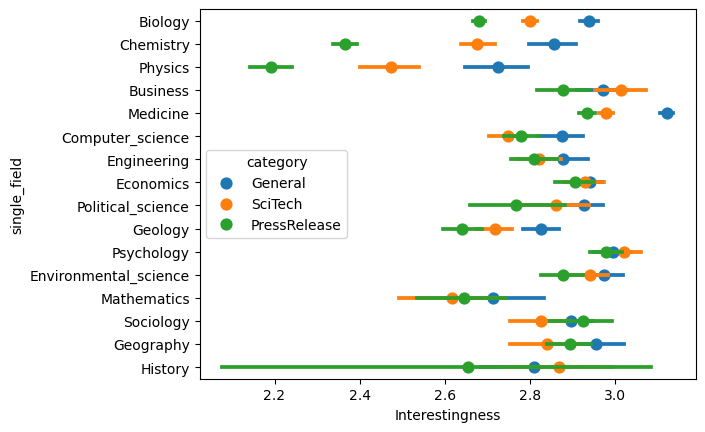

In [449]:
sns.pointplot(y='single_field',x='Interestingness', hue='category', data=df[df['single_field'].isin(top_fields)], linestyle='none')

In [479]:
sel_statements

{'Should be published in news': 'Newsworthiness',
 'Tackles an important issue': 'Importance',
 'I understand the news story': 'Understandability',
 'Could benefit many people': 'Benefit',
 'Could interest the general public': 'Interestingness',
 'News story is fun to read': 'Fun'}

Text(33.222222222222214, 0.5, '')

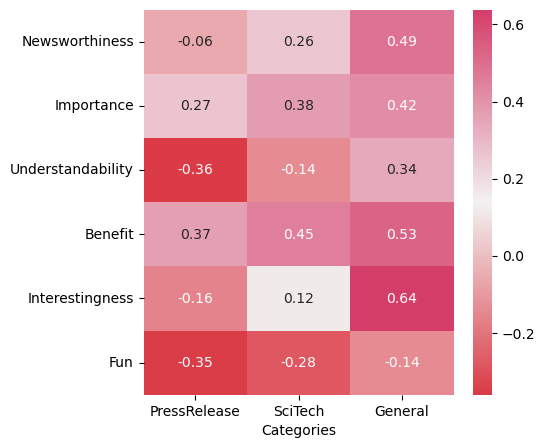

In [486]:
keys = sel_statements.values()
categories = ['PressRelease','SciTech', 'General']
correlation_matrix = []

for key in keys:
    key_correlations = []
    for category in categories:
        category_df = df[df['category'] == category]
        t_df = category_df[category_df['single_field'].isin(top_fields)][['single_field', key]].groupby('single_field').mean().reset_index().sort_values('single_field')
        t_df['count'] = category_df[category_df['single_field'].isin(top_fields)][['single_field', key]].groupby('single_field').count().reset_index().sort_values('single_field')[key]
        correlation = t_df[key].corr(t_df['count'])
        key_correlations.append(correlation)
    correlation_matrix.append(key_correlations)

correlation_df = pd.DataFrame(correlation_matrix, columns=categories, index=keys)
cmap = sns.diverging_palette(10, 0, as_cmap=True)
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_df, annot=True, cmap=cmap, fmt=".2f")
plt.title("")
plt.xlabel("Categories")
plt.ylabel("")

-0.36083110916079875
0.33905727955903714
-0.14135973296432666


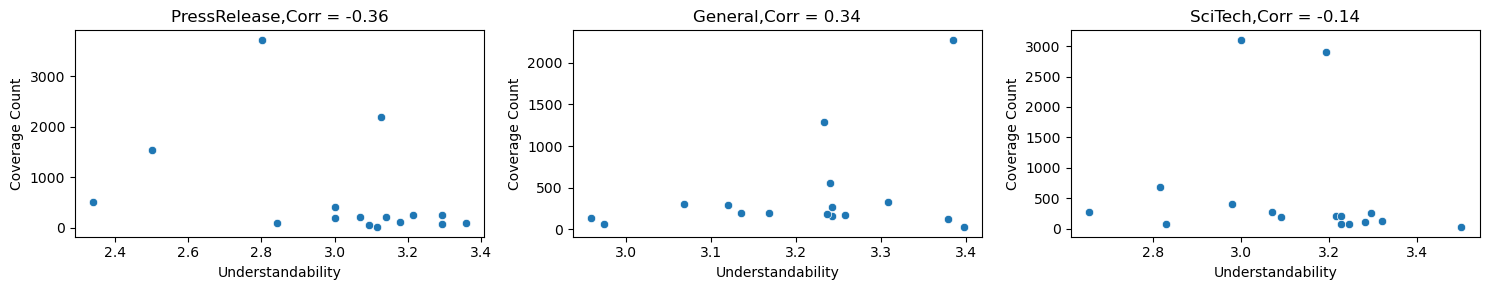

In [477]:
key = 'Understandability'
categories = ['PressRelease', 'General', 'SciTech']

fig, axes = plt.subplots(ncols=len(categories), figsize=(5*len(categories), 3))

for i, category in enumerate(categories):
    category_df = df[df['category'] == category]
    
    t_df = category_df[category_df['single_field'].isin(top_fields)][['single_field', key]].groupby('single_field').mean().reset_index().sort_values('single_field')
    t_df['count'] = category_df[category_df['single_field'].isin(top_fields)][['single_field', key]].groupby('single_field').count().reset_index().sort_values('single_field')[key]
    t_df['value_rank'] = t_df[key].rank(ascending=False)
    t_df['count_rank'] = t_df['count'].rank(ascending=False)
    t_df = t_df.sort_values('count')
    
    sns.scatterplot(x=key, y='count', data=t_df, ax=axes[i])
    #for index, row in t_df.iterrows():
    #    axes[i].text(row['value_rank'], row['count_rank'], row['single_field'], color='black', ha='left', va='bottom')
    #axes[i].set_xlim(max(t_df['value_rank']) + 1, min(t_df['value_rank']) - 1)
    #axes[i].set_ylim(max(t_df['count_rank']) + 1, min(t_df['count_rank']) - 1)
    axes[i].set_xlabel('Understandability')
    axes[i].set_ylabel('Coverage Count')
    axes[i].set_title(category + ',Corr = {:.2f}'.format(t_df[key].corr(t_df['count'])))
    print(t_df[key].corr(t_df['count']))
    #axes[i].text(0, 0, 'Corr = {:.2f}'.format(t_df[key].corr(t_df['count'])), color='red')

plt.tight_layout()

-0.05666075740054755
0.4893291369814806
0.25838887341121364


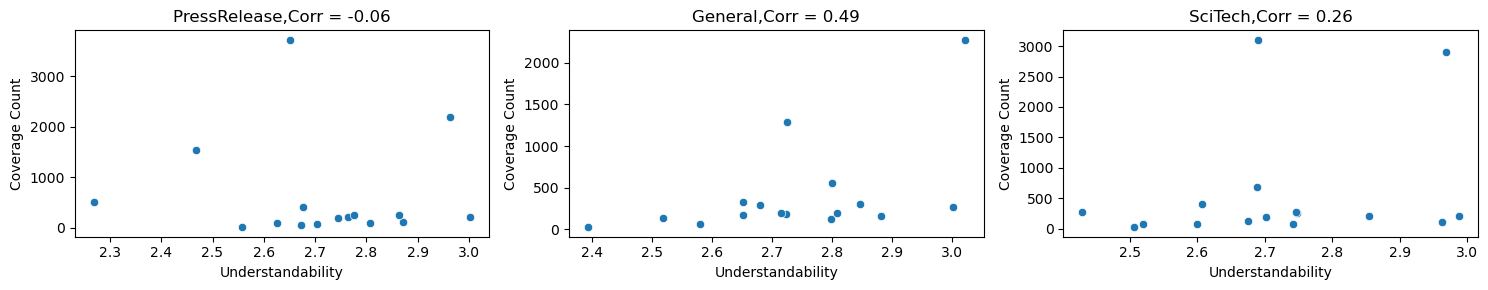

In [478]:
key = 'Newsworthiness'
categories = ['PressRelease', 'General', 'SciTech']

fig, axes = plt.subplots(ncols=len(categories), figsize=(5*len(categories), 3))

for i, category in enumerate(categories):
    category_df = df[df['category'] == category]
    
    t_df = category_df[category_df['single_field'].isin(top_fields)][['single_field', key]].groupby('single_field').mean().reset_index().sort_values('single_field')
    t_df['count'] = category_df[category_df['single_field'].isin(top_fields)][['single_field', key]].groupby('single_field').count().reset_index().sort_values('single_field')[key]
    t_df['value_rank'] = t_df[key].rank(ascending=False)
    t_df['count_rank'] = t_df['count'].rank(ascending=False)
    t_df = t_df.sort_values('count')
    
    sns.scatterplot(x=key, y='count', data=t_df, ax=axes[i])
    #for index, row in t_df.iterrows():
    #    axes[i].text(row['value_rank'], row['count_rank'], row['single_field'], color='black', ha='left', va='bottom')
    #axes[i].set_xlim(max(t_df['value_rank']) + 1, min(t_df['value_rank']) - 1)
    #axes[i].set_ylim(max(t_df['count_rank']) + 1, min(t_df['count_rank']) - 1)
    axes[i].set_xlabel('Understandability')
    axes[i].set_ylabel('Coverage Count')
    axes[i].set_title(category + ',Corr = {:.2f}'.format(t_df[key].corr(t_df['count'])))
    print(t_df[key].corr(t_df['count']))
    #axes[i].text(0, 0, 'Corr = {:.2f}'.format(t_df[key].corr(t_df['count'])), color='red')

plt.tight_layout()

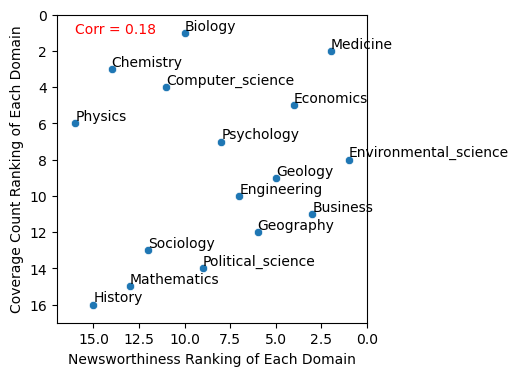

In [391]:
t_df = df[df['single_field'].isin(top_fields)][['single_field',key]].groupby('single_field').mean().reset_index().sort_values('single_field')
t_df['count'] = df[df['single_field'].isin(top_fields)][['single_field',key]].groupby('single_field').count().reset_index().sort_values('single_field')[key]
t_df['value_rank'] = t_df[key].rank(ascending=False)
t_df['count_rank'] = t_df['count'].rank(ascending=False)
t_df = t_df.sort_values('count')
fig, axes = plt.subplots(figsize=(4, 4)) 
a = 'value_rank'
b = 'count_rank'
sns.scatterplot(x=a, y=b,data=t_df)
for index, row in t_df.iterrows():
    plt.text(row[a], row[b], row['single_field'], color='black', ha='left', va='bottom')
plt.xlim(max(t_df[a]) + 1, min(t_df[a]) - 1)
plt.ylim(max(t_df[b]) + 1, min(t_df[b]) - 1)
#plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.title('Corr = 0.18')
plt.xlabel('Newsworthiness Ranking of Each Domain')
plt.ylabel('Coverage Count Ranking of Each Domain')
plt.text(16,1, 'Corr = 0.18', color='red')
plt.savefig('../shared_data/figures/coverage_cnt_value_ranking_domain_scatter.pdf', bbox_inches='tight')

(113.0, 0.0)

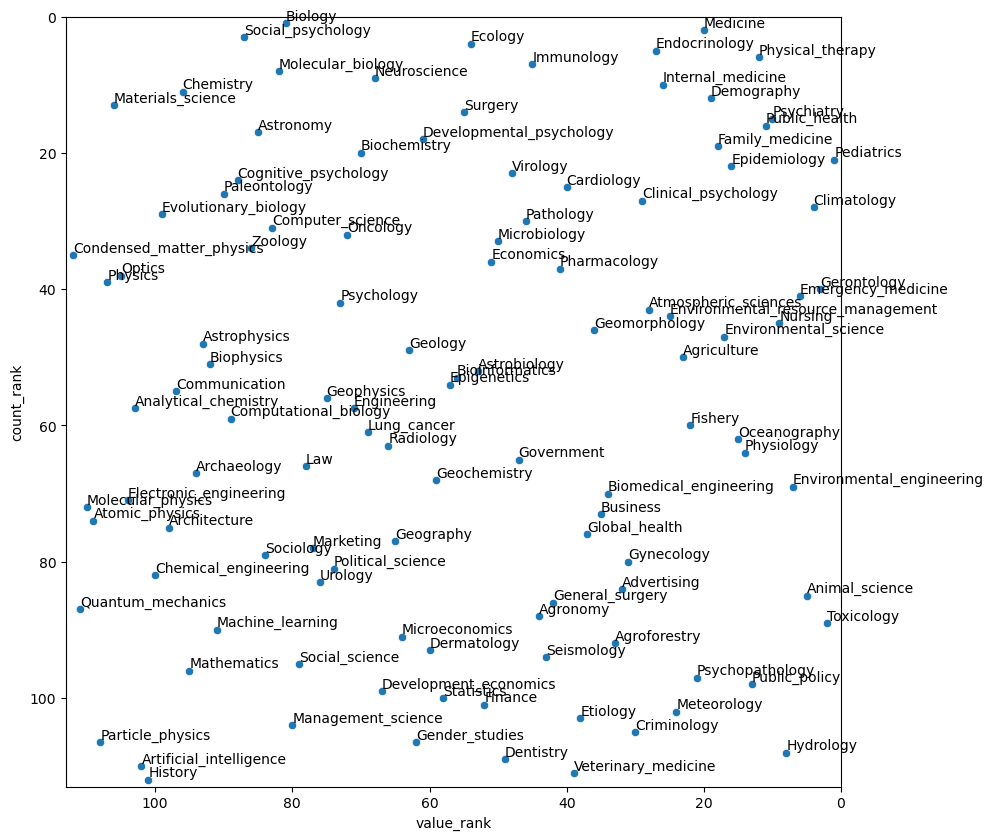

In [376]:
t_df = df[['single_field',key]].groupby('single_field').mean().reset_index().sort_values('single_field')
t_df['count'] = df[['single_field',key]].groupby('single_field').count().reset_index().sort_values('single_field')[key]
t_df['value_rank'] = t_df[key].rank(ascending=False)
t_df['count_rank'] = t_df['count'].rank(ascending=False)
t_df = t_df.sort_values('count')

fig, axes = plt.subplots(figsize=(10, 10)) 

a = 'value_rank'
b = 'count_rank'
sns.scatterplot(x=a, y=b,data=t_df)
for index, row in t_df.iterrows():
    plt.text(row[a], row[b], row['single_field'], color='black', ha='left', va='bottom')
plt.xlim(max(t_df[a]) + 1, min(t_df[a]) - 1)
plt.ylim(max(t_df[b]) + 1, min(t_df[b]) - 1)

In [367]:
t_df[a].corr(t_df[b])

0.18670421249741084

In [359]:
t_df[a].corr(t_df[b])

0.22545885854711295

ValueError: Could not interpret value `count` for `x`. An entry with this name does not appear in `data`.

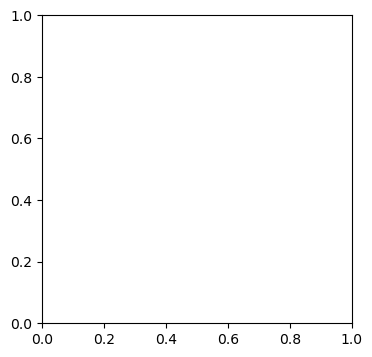

In [498]:
fig, axes = plt.subplots(figsize=(4, 4)) 
b = 'Newsworthiness'
a = 'count'
sns.scatterplot(x=a, y=b,data=t_df)
for index, row in t_df.iterrows():
    plt.text(row[a], row[b], row['single_field'], color='black', ha='left', va='bottom')
#plt.xlim(max(t_df[a]) + 1, min(t_df[a]) - 1)
#plt.ylim(max(t_df[b]) + 1, min(t_df[b]) - 1)

In [419]:
df['doi_newsworthiness'] = df[['doi','Newsworthiness']].groupby('doi').transform('mean')['Newsworthiness']

In [420]:
t_df = df.drop_duplicates('doi')
t_df.coverage_cnt.corr(df.doi_newsworthiness)

0.07710141318699362

Text(0, 0.5, 'Coverage Count')

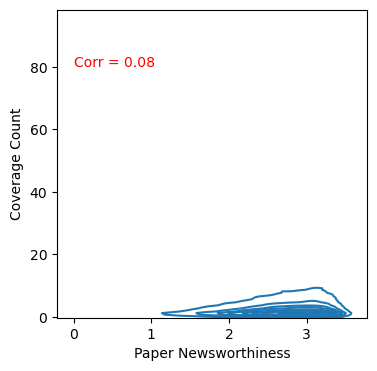

In [438]:
fig, axes = plt.subplots(figsize=(4, 4))
plt.text(0,80, 'Corr = 0.08', color='red')
sns.kdeplot(y='coverage_cnt', x='doi_newsworthiness', data=df.drop_duplicates('doi'),ax=axes)
plt.xlabel('Paper Newsworthiness')
plt.ylabel('Coverage Count')
#plt.savefig('../shared_data/figures/coverage_cnt_value_ranking_article_hist.pdf', bbox_inches='tight')

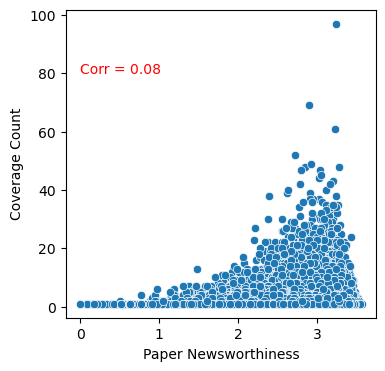

In [430]:
fig, axes = plt.subplots(figsize=(4, 4))
plt.text(0,80, 'Corr = 0.08', color='red')
sns.scatterplot(y='coverage_cnt', x='doi_newsworthiness', data=df.drop_duplicates('doi'),ax=axes)
plt.xlabel('Paper Newsworthiness')
plt.ylabel('Coverage Count')
plt.savefig('../shared_data/figures/coverage_cnt_value_ranking_article_hist.pdf', bbox_inches='tight')

/tmp/ipykernel_2810945/3229493580.py:2: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




Text(0.5, 0, 'count')

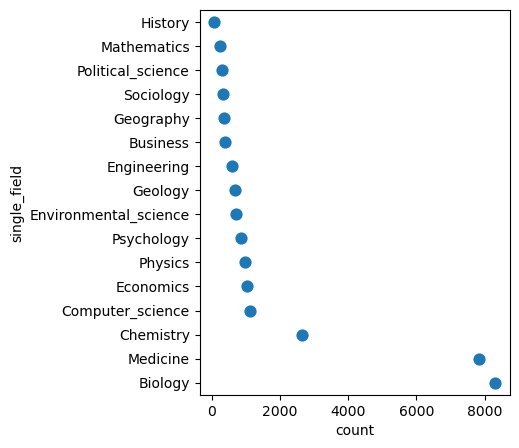

In [436]:
fig, ax = plt.subplots(figsize=(4, 5)) 
sns.pointplot(y='single_field', x=key, data=df[df['single_field'].isin(top_fields)][['single_field',key]].groupby('single_field').count().reset_index().sort_values(key), join=False)
plt.xlabel('count')

In [249]:
doi2data = {}
for i,row in tqdm(df.iterrows()):
    if row['doi'] not in doi2data:
        doi2data[row['doi']] = defaultdict(list)
    if row['distance_to_pr'] != None and row['distance_to_pr'] < 1000:
        continue
    doi2data[row['doi']][row['category']].append(row)

125685it [00:38, 3250.55it/s]


In [564]:
re_df = defaultdict(list)
for doi,v in tqdm(doi2data.items()):
    re_df['doi'].append(doi)
    for key in ['General', 'PressRelease', 'SciTech']:
        re_df[key].append(len(doi2data[doi][key]) if key in doi2data[doi] else 0)
re_df = pd.DataFrame(re_df)

cv_dict = {}
cv_dict['all'] = re_df[(re_df.PressRelease!=0)&((re_df.General!=0)&(re_df.SciTech!=0))]#.sample(10)
cv_dict['pr_sci'] = re_df[(re_df.PressRelease!=0)&((re_df.General==0)&(re_df.SciTech!=0))]#.sample(10)
cv_dict['pr_gen'] = re_df[(re_df.PressRelease!=0)&((re_df.General!=0)&(re_df.SciTech==0))]#.sample(10)
cv_dict['pr_only'] = re_df[(re_df.PressRelease!=0)&((re_df.General==0)&(re_df.SciTech==0))]#.sample(30)
cv_dict['gen_only'] = re_df[(re_df.PressRelease==0)&((re_df.General!=0)&(re_df.SciTech==0))]#.sample(30)
cv_dict['sci_only'] = re_df[(re_df.PressRelease==0)&((re_df.General==0)&(re_df.SciTech!=0))]#.sample(30)
#sel_dois = set(pd.concat([cv_dict['all_covered'], cv_dict['pr_sci_covered'], cv_dict['pr_gen_covered'], cv_dict['pr_only_covered']])['doi'])
#print(len(sel_dois))

doi2type = {}
for key,value in cv_dict.items():
    for doi in value['doi']:
        doi2type[doi] = key

100%|██████████████████████████████████████████████████████████████████████████| 56686/56686 [00:00<00:00, 245143.51it/s]


In [570]:
df['coverage_type'] = [doi2type[d] if d in doi2type else None for d in df['doi']]

In [571]:
df['coverage_type'].value_counts()

coverage_type
pr_only     34560
all         29629
pr_sci      15850
sci_only    13927
gen_only    11223
pr_gen       6073
Name: count, dtype: int64

In [254]:
t_df = df[df['coverage_type']=='all_covered']

In [487]:
news_values = list(sel_statements.values())


In [490]:
res_df = pd.DataFrame()
for key in news_values:
    print(key)
    t_df = df[df['coverage_type']=='all_covered']
    t_df['category'] = ['0' if c == 'PressRelease' else c for c in t_df.category]
    #t_df = all_df[all_df['statement'] == key].rename(columns=question2key)
    #t_df = t_df[~t_df.score.isna()]
    #t_df['education'] = ['0' if it == 'High school diploma or equivalent' else it for it in t_df['education']]
    #t_df = t_df.reset_index().drop(columns=['index']).reset_index()
    mod = ols(formula = key + ' ~ category + big_field + top_journal + journal_impact',
                          data=t_df)
    res = mod.fit()
    #print(res.summary())
    t_df =  results_summary_to_dataframe(res)
    t_df['statement'] = key
    res_df = pd.concat([res_df, t_df])

Newsworthiness


/tmp/ipykernel_2810945/3993979919.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Importance


/tmp/ipykernel_2810945/3993979919.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Understandability


/tmp/ipykernel_2810945/3993979919.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Benefit


/tmp/ipykernel_2810945/3993979919.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Interestingness


/tmp/ipykernel_2810945/3993979919.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Fun


/tmp/ipykernel_2810945/3993979919.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/tmp/ipykernel_2810945/2064387917.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2810945/2064387917.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2810945/65193511.py:49: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/tmp/ipykernel_2810945/65193511.py:103: UserWarning:

FixedFormatter should only b

[<matplotlib.lines.Line2D object at 0x7fa4b8132ad0>, <matplotlib.lines.Line2D object at 0x7fa4b815c7d0>, <matplotlib.lines.Line2D object at 0x7fa4b8162510>, <matplotlib.lines.Line2D object at 0x7fa4b816cb90>, <matplotlib.lines.Line2D object at 0x7fa4b817ea90>, <matplotlib.lines.Line2D object at 0x7fa4b80ebed0>] ['Newsworthiness', 'Importance', 'Understandability', 'Benefit', 'Interestingness', 'Fun']


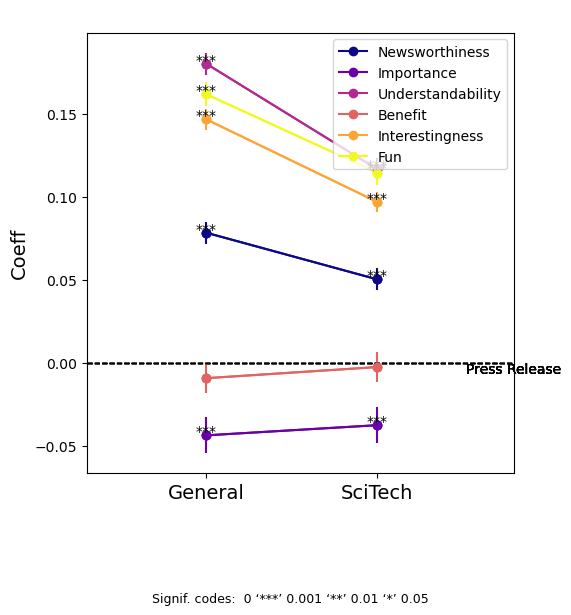

In [530]:
t_df = res_df[res_df['term'].str.contains('category')]
t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
#t_df = t_df.sort_values('coeff')
t_df['dv'] = t_df['statement']
#t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
plot_reg_results_dv_pointplot(t_df, dvs = t_df.statement.unique(), terms=['General','SciTech'], labels=None, figsize=(5, 5), title=' ', figtype='pointplot',cmap = 'plasma',baseline=0.00,
                             filename=None, legend=None, wspace=0.35, yticks=None, ytick_labels=None, ylabel='Coeff', ylim=None, xlabel=None, sig=True)

In [568]:
res_df = pd.DataFrame()
for key in news_values:
    print(key)
    t_df = df[df['category']=='PressRelease']
    #t_df['category'] = ['0' if c == 'PressRelease' else c for c in t_df.category]
    #t_df = all_df[all_df['statement'] == key].rename(columns=question2key)
    #t_df = t_df[~t_df.score.isna()]
    #t_df['education'] = ['0' if it == 'High school diploma or equivalent' else it for it in t_df['education']]
    #t_df = t_df.reset_index().drop(columns=['index']).reset_index()
    mod = ols(formula = key + ' ~ coverage_type + big_field + top_journal + journal_impact',
                          data=t_df)
    res = mod.fit()
    #print(res.summary())
    t_df =  results_summary_to_dataframe(res)
    t_df['statement'] = key
    res_df = pd.concat([res_df, t_df])

Newsworthiness
Importance
Understandability
Benefit
Interestingness
Fun


In [569]:
res_df[res_df['term'].str.contains('type')]

,index,p value,coeff,SE,conf_lower,conf_higher,term,statement
1,coverage_type[T.pr_gen],2.824170e-01,-0.012359,0.011498,-0.034895,0.010177,coverage_type[T.pr_gen],Newsworthiness
2,coverage_type[T.pr_only],8.069794e-83,-0.135581,0.007015,-0.149330,-0.121832,coverage_type[T.pr_only],Newsworthiness
3,coverage_type[T.pr_sci],2.942596e-07,-0.043211,0.008426,-0.059726,-0.026695,coverage_type[T.pr_sci],Newsworthiness
1,coverage_type[T.pr_gen],2.319743e-11,0.099581,0.014893,0.070390,0.128772,coverage_type[T.pr_gen],Importance
2,coverage_type[T.pr_only],1.166760e-21,0.086927,0.009086,0.069118,0.104736,coverage_type[T.pr_only],Importance
3,coverage_type[T.pr_sci],4.424710e-12,0.075587,0.010915,0.054194,0.096980,coverage_type[T.pr_sci],Importance
1,coverage_type[T.pr_gen],1.445240e-07,-0.070707,0.013441,-0.097053,-0.044362,coverage_type[T.pr_gen],Understandability
2,coverage_type[T.pr_only],2.777524e-284,-0.298116,0.008201,-0.314190,-0.282043,coverage_type[T.pr_only],Understandability
3,coverage_type[T.pr_sci],1.790870e-50,-0.147405,0.009851,-0.166713,-0.128097,coverage_type[T.pr_sci],Understandability
1,coverage_type[T.pr_gen],3.697726e-07,0.065729,0.012927,0.040393,0.091066,coverage_type[T.pr_gen],Benefit


/tmp/ipykernel_2810945/3509718323.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2810945/3509718323.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2810945/2546419328.py:49: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/tmp/ipykernel_2810945/2546419328.py:103: UserWarning:

FixedFormatter should on

[<matplotlib.lines.Line2D object at 0x7fa67d76b350>, <matplotlib.lines.Line2D object at 0x7fa67d810390>, <matplotlib.lines.Line2D object at 0x7fa67d630390>, <matplotlib.lines.Line2D object at 0x7fa67d64da10>, <matplotlib.lines.Line2D object at 0x7fa67d7925d0>, <matplotlib.lines.Line2D object at 0x7fa67d681710>] ['Newsworthiness', 'Importance', 'Understandability', 'Benefit', 'Interestingness', 'Fun']


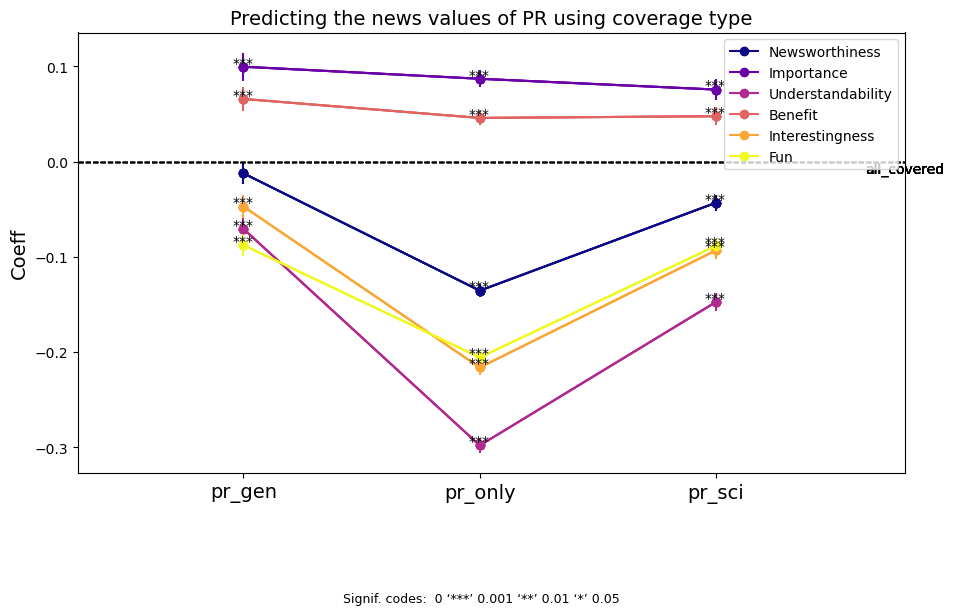

In [573]:
t_df = res_df[res_df['term'].str.contains('type')]
t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
#t_df = t_df.sort_values('coeff')
t_df['dv'] = t_df['statement']
#t_df = t_df[t_df['statement']=='Newsworthiness']
#t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
plot_reg_results_dv_pointplot(t_df, dvs = t_df.statement.unique(),labels=None, figsize=(9, 5), title='Predicting the news values of PR using coverage type', figtype='pointplot',cmap = 'plasma',baseline=0.00,baseline_text='all_covered',
                             filename=None, legend=None, wspace=0.35, yticks=None, ytick_labels=None, ylabel='Coeff', ylim=None, xlabel=None, sig=True)


[Text(0.5, 0, 'Newsworthiness'),
 Text(1.5, 0, 'Importance'),
 Text(2.5, 0, 'Understandability'),
 Text(3.5, 0, 'Benefit'),
 Text(4.5, 0, 'Interestingness'),
 Text(5.5, 0, 'Fun')]

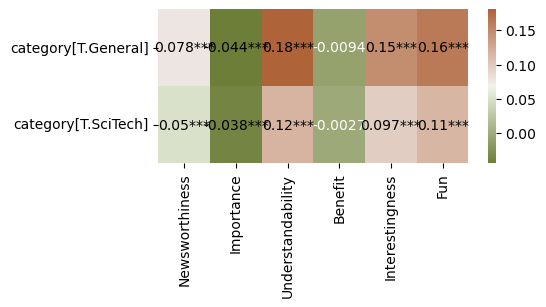

In [495]:
r_df = res_df[res_df['term'].str.contains('category')]
terms = list(r_df.drop_duplicates('term').term)#[1:]
heat_dict = defaultdict(list)
for col in news_values:
    for c in terms:
        t_df = r_df[r_df['statement']==col]#[1:]
        t_df.index = t_df['index']
        t_df = t_df.reindex(terms)
        heat_dict[col] = [(coeff, p) for coeff, p in zip(t_df['coeff'], t_df['p value'])]
        #except:
        #    continue
#heat_df = pd.DataFrame(heat_dict)
#heat_df.index=terms

heat_values = pd.DataFrame({col: [val[0] for val in vals] for col, vals in heat_dict.items()}, index=terms)
p_values = pd.DataFrame({col: [val[1] for val in vals] for col, vals in heat_dict.items()}, index=terms)

fig, ax = plt.subplots(figsize=(5,2))     

# Define a custom color palette
cmap = sns.diverging_palette(100, 30, as_cmap=True)

# Create the heatmap
ax = sns.heatmap(heat_values, annot=True, cmap=cmap)

for text in ax.texts:
    # Extract position from text object
    text_position = [int(i-0.5) for i in text.get_position()]
    #print(text_position)
    #print(round(text_position[1]), round(text_position[0]))
    p_value = p_values.iloc[text_position[1], text_position[0]]
    if p_value >= 0.05:
        # Set the color of non-significant cells to white
        #text.set_color('white')  # Set text color to black for visibility
        # Find the patch (rectangle) corresponding to the text and set its color to white
        #patch = ax.patches[text_position[1] * len(p_values.columns) + text_position[0]]
        #patch.set_facecolor('lightgrey')
        continue
    else:
        text.set_color('black')
    text.set_text(text.get_text() + add_star(p_value))

# Rotate the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)